In [1]:
import librosa
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import  Flatten,Dense,Dropout
from tensorflow.keras import Sequential
from tensorflow import keras
warnings.simplefilter('ignore')

In [2]:
def load_and_extract_features(directory_path, sr=22050):
    """
    Load audio files from a directory, extract features, and return them as a numpy array.
    
    Parameters:
    - directory_path: str, path to the directory containing audio files.
    - sr: int, sample rate for audio files. Default is 22050.
    
    Returns:
    - features_data: numpy array, extracted features from all audio files.
    """
    label=[]
    feature_names = ['mfcc', 'chroma', 'mel', 'contrast', 'tonnetz']
    data = np.zeros((0, 173))  # Initialize empty array with correct shape
    # Iterate over audio files in the directory
    for root, dirs, files in os.walk(directory_path):
        # print(root)
        limit=0
        for filename in files:
            if filename.endswith('.mp3'):
                if limit<10:
                    file_path = os.path.join(root, filename)
                    # Load audio file
                    y, sr = librosa.load(file_path, sr=sr)
                    # Extract features
                    mfcc = librosa.feature.mfcc(y=y, sr=sr)
                    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                    mel = librosa.feature.melspectrogram(y=y, sr=sr)
                    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
                    # Concatenate features and append to data
                    features = np.concatenate([mfcc, chroma, mel, contrast, tonnetz], axis=0).T
                    label_name=root.replace('/data/bucket_2', '')
                    file_name=[label_name]*features.shape[0]
                    label=label+file_name
                    data = np.vstack((data, features))
                limit=limit+1
    label=np.array(label)
    data = np.delete(data, 0, axis=0)
    label = np.delete(label, 0)
    return data,label

In [3]:
directory_path = 'data/bucket_2'
data,data_label=load_and_extract_features(directory_path)

In [4]:
label_to_int = {label: idx for idx, label in enumerate(np.unique(data_label))}
int_labels = np.array([label_to_int[label] for label in data_label])
num_labels=len(label_to_int)

X_train, X_test, y_train, y_test = train_test_split(data, int_labels, test_size=0.3)

# Map string labels to integers
# label_to_int_train = {label: idx for idx, label in enumerate(np.unique(y_train))}
# int_labels_train = np.array([label_to_int_train[label] for label in y_train])
# label_to_int_test= {label: idx for idx, label in enumerate(np.unique(y_test))}
# int_labels_test = np.array([label_to_int_train[label] for label in y_test])

from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [ ]:
model=Sequential([
    Flatten(input_shape=(X_train.shape[1],)),  
    # 1st dense layer
    Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    Dropout(0.3),
    # 2nd dense layer
    Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    Dropout(0.3),
    # 3rd dense layer
    Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    Dropout(0.3),
    # output layer
    Dense(num_labels, activation='softmax')
]
    
)
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',  # Use categorical_crossentropy for one-hot encoded labels
              metrics=['accuracy'])
model.summary()

#train model
history = model.fit(X_train, train_labels, validation_data=(X_test, test_labels), batch_size=32, epochs=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 173)               0         
                                                                 
 dense (Dense)               (None, 512)               89088     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

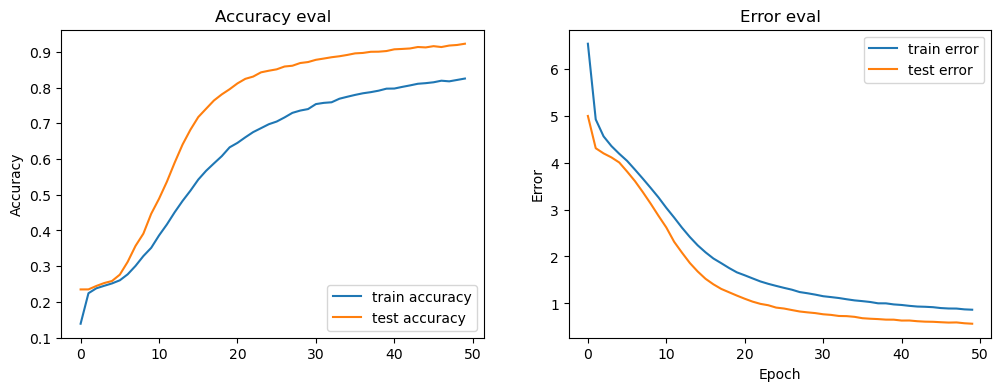

In [18]:
plot_history(history)